# IMPORTS

In [37]:
# Imports  
import cv2
import os 
import tensorflow
import math
import pywt

import keras
import matplotlib.pyplot as plot
import matplotlib.image as mpimg

import numpy as np
import glob
import pickle
# from skimage.feature import 
from scipy.interpolate import interp1d

print('done')


done


In [38]:
# Hough Transform
def process_hough(imagepath, image, radius): # Returns (image, radius, success<true>) / (image, image.shape[0], success<false>)
    success = False
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(image, 11)
    ret, _ = cv2.threshold(
        gray, 0, 255, (cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    )

    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )
    # try:
    circles = circles[0, :, :]
    circles = np.int16(np.array(circles))
    for i in circles[:]:
        image = image[
            i[1] - i[2] - radius: i[1] + i[2] + radius, i[0] - i[2] - radius: i[0] + i[2] + radius
            # i[1] - i[2] : i[1] + i[2], i[0] - i[2] : i[0] + i[2]
        ]
        radius = i[2]
    success = True   
    return (image, radius, success)
    
    # except:
    #     image[:] = 255
    #     print(f"{imagepath} -> No circles (iris) found.")
    #     success = False
    #     cv2.imshow("Image", image)
    #     # Wait for a key press (blocks execution)
    #     cv2.waitKey(0)
    #     return (image, image.shape[0], success)

In [39]:
# Fix Images
def remove_reflection(image): #returns image
    ret, mask = cv2.threshold(
        image, 150, 255, cv2.THRESH_BINARY
    )
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    image_rr = cv2.inpaint(
        image, dilation, 5, cv2.INPAINT_TELEA
    )

    return image_rr

In [40]:
# Daugman Rubber Sheet Model
def generate_rubber_sheet_model(image): #returns image
    q = np.arange(0.00, np.pi * 2, 0.01)
    inn = np.arange(0, int(image.shape[0] / 2), 1)

    cartisian_image = np.empty(shape=[inn.size, int(image.shape[1]), 3])
    m = interp1d([np.pi * 2, 0], [0, image.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + image.shape[1] / 2)
            polarY = int((r * np.sin(t)) + image.shape[0] / 2)
            try:
                cartisian_image[r][int(m(t) - 1)] = image[polarY][polarX]
            except:
                pass

    return cartisian_image.astype("uint8")

In [41]:
# Parse Iris Dataset
def parse_iris_dataset(keep_reflections): # Returns images(image, image_id, label)
    # eye_num_2 = 0
    # final_output = []
    # lables = []
    label = 0
    eye_images = []
    eye_L_images = []
    eye_R_images = []

    base_directory = 'Dataset/VISA_Iris/VISA_Iris'

    for path in glob.iglob(base_directory+'/*'):
        foldername = os.path.basename(path)
        label = foldername
        print('label: ' + label)
        image_id = 1

        # Process Left Eye
        for image_path in glob.iglob(path+'/L/*'):
            image = cv2.imread(image_path)
                
            image_hough_processed = process_hough(
                image_path, image, 50)  # hough transform

            if (keep_reflections):
                remove_reflection(image)
                
            (testimage, x, success) = image_hough_processed  
            if (success):
                eye_L_images.append([image_hough_processed, image_id, label])  # just left iris
                eye_images.append([image_hough_processed, image_id, label])
                image_id += 1
            else: pass
        print('L eye: ' + str(len(eye_L_images)))
        
        image_id = 1
        # Process Right Eye
        for image_path in glob.iglob(path+'/R/*'):
            image = cv2.imread(image_path)
                
            image_hough_processed = process_hough(image_path, image, 50)  # hough transform
            
            if (keep_reflections):
                remove_reflection(image_hough_processed)

            # image = cv2.resize(image, (400, 300))
            (testimage, x, success) = image_hough_processed  
            if (success):
                eye_R_images.append([image_hough_processed, image_id, label])
                eye_images.append([image_hough_processed, image_id, label])
                image_id += 1
            else: pass
        print('R iris: ' + str(len(eye_R_images)))

        # old code insert here
    print('iris images: ' + str(len(eye_images)))
    
    return eye_images

    # OLD CODE
    # for image_path in glob.iglob(path+'/L/*'):
    #     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #     image = cv2.resize(image, (400, 300))
    #     eye_L_images.append([image, image_id, label]) #just left iris
    #     eye_images.append([image, image_id, label])
    #     image_id += 1
    # print('L eye: ' + str(len(eye_L_images)))

    # for image_path in glob.iglob(path+'/R/*'):
    #     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #     image = cv2.resize(image, (400, 300))
    #     eye_R_images.append([image, image_id, label]) #just right iris
    #     eye_images.append([image, image_id, label])
    #     image_id += 1
    # print('R iris: ' + str(len(eye_R_images)))

In [48]:
# Proccess to Daugman
def proccess_images(eye_images):
    for eye_image in eye_images:
        (hough_information, image_id, label) = eye_image
        (image, radius, success) = hough_information
        print(str(image_id) + ': ' + str(success))
        if(success == True):
            image_daugman = generate_rubber_sheet_model(image)
        else:
            cv2.imshow(image)
            cv2.waitKey(0)
        print("id" + str(image_id))
        cv2.imwrite(
            'Iris_Output/'+str(label)+ '.' + str(image_id) + '.Iris' + '.bmp',
            image_daugman
        )      

In [49]:
keep_reflections = False
eye_images = parse_iris_dataset(keep_reflections)
stuff = proccess_images(eye_images)

label: S0001_F_30
L eye: 19
R iris: 26
iris images: 45


TypeError: can only concatenate str (not "bool") to str

In [ ]:
# OBSOLETE - Detect Iris using Iris Cascade
def detect_iris(eye_images, display):
    eye_num_2 = 0
    eyes_num = 0
    # explain how this works in presentation
    eye_cascade = cv2.CascadeClassifier('haarcascade_iris.xml')
    for eye_image in eye_images:
        (image, image_id, label) = eye_image
        image_id += 1
        eyes = eye_cascade.detectMultiScale(image, 1.1, 0)

        if len(eyes) > 1:  # idk what is happening
            eyes_num = eyes_num + 1
            maxium_area = -3
        
        for (x, y, width, height) in eyes:
            area = width * height

            if area > maxium_area:
                maxium_area = area
                maxium_width = width
                point_x = x
                point_y = y
                maxium_height = height
            
        image_unboxed = image.copy()

        image_cropped = image_unboxed[point_y:point_y + maxium_height,
                                      point_x:point_x + maxium_width,]

        image_boxed = cv2.rectangle(
            image,
            (point_x, point_y),
            (point_x + maxium_width, point_y + maxium_height),
            (255, 0, 0),
            2,
        )

        cv2.imwrite(
            'Processed/'+str(label)+ '.' + str(image_id) + '.Iris' + '.bmp',
            image_cropped
        )
        
    print("iris image preprocessing done")
    
    if (display):
        fig, axes = plot.subplots(1, 3, figsize=(12, 5))

        axes[0].imshow(image_unboxed)
        axes[0].set_title('Original Image')
        axes[0].axis('off')  # Hide axes for cleaner presentation

        axes[1].imshow(image_boxed)
        axes[1].set_title('Iris Detection')
        axes[1].axis('off')

        axes[2].imshow(image_cropped)
        axes[2].set_title('Cropped Image')
        axes[2].axis('off')

        plot.tight_layout()
        plot.show()

    print("total_eyes_found = ", eyes_num)
    print("total_eyes_found 2 = ", eye_num_2)
    print("total images: ", len(eye_images))

eye_images = parse_iris_dataset()
detect_iris(eye_images, 1)

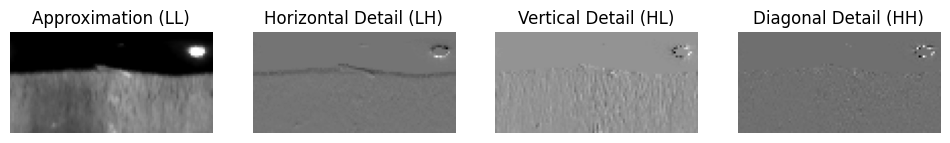

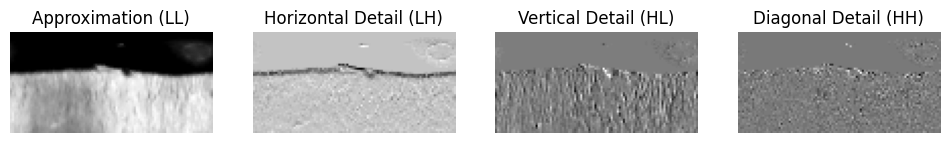

DWT Features: [142.8751, 116.8818204426591, 510.00000000000006, 0.0, 181.00000000000003, -1.0773, 8.276048254450913, 180.00000000000003, -150.00000000000003, 0.0, -0.14510000000000053, 7.175673904937432, 94.00000000000001, -127.00000000000001, 0.0, 0.0789, 3.984535705700227, 95.00000000000001, -73.00000000000001, 0.0]
DWT Features N: [137.5866, 112.22945914705285, 297.00000000000006, 0.0, 180.0, -1.0798, 5.629567653026297, 16.000000000000004, -52.000000000000014, 0.0, -0.011800000000000426, 5.447812474746172, 33.50000000000001, -31.999999999999996, 0.0, 0.007400000000000008, 2.128930539026579, 19.500000000000004, -18.0, 0.0]


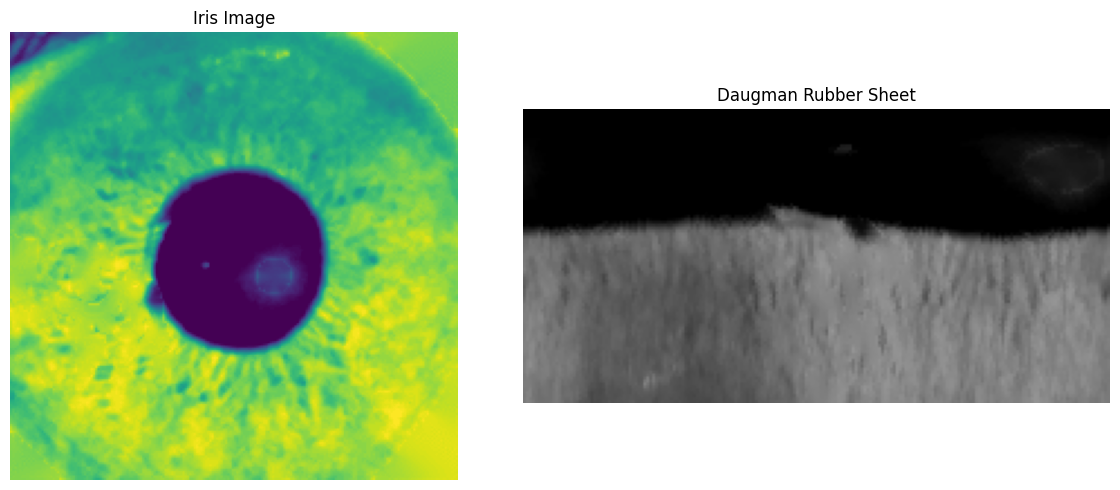

In [ ]:
#For Display
from matplotlib import pyplot as plt

def processing(image_path, r):
    success = False
    image = cv2.imread(image_path)
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(image, 11)
    ret, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )
    try:
        circles = circles[0, :, :]
        circles = np.int16(np.array(circles))
        for i in circles[:]:
            image = image[
                i[1] - i[2] - r : i[1] + i[2] + r, i[0] - i[2] - r : i[0] + i[2] + r
                # i[1] - i[2] : i[1] + i[2], i[0] - i[2] : i[0] + i[2]
            ]
            radius = i[2]
        success = True
        return image, radius, success
    except:
        image[:] = 255
        print(f"{image_path} -> No circles (iris) found.")
        success = False
        return image, image.shape[0], success

def generate_rubber_sheet_model(img):
    q = np.arange(0.00, np.pi * 2, 0.01)
    inn = np.arange(0, int(img.shape[0] / 2), 1)

    cartisian_image = np.empty(shape=[inn.size, int(img.shape[1]), 3])
    m = interp1d([np.pi * 2, 0], [0, img.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + img.shape[1] / 2)
            polarY = int((r * np.sin(t)) + img.shape[0] / 2)
            try:
                cartisian_image[r][int(m(t) - 1)] = img[polarY][polarX]
            except:
                pass

    return cartisian_image.astype("uint8")

def remove_reflection(img):
    ret, mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    dst = cv2.inpaint(img, dilation, 5, cv2.INPAINT_TELEA)
    return dst

def feature_extraction(img):
    features = []
    ccoeffs = pywt.dwt2(img[:, :, 0], 'haar')
    LL, (LH, HL, HH) = ccoeffs
    for coef in [LL, LH, HL, HH]:
        features.append(np.mean(coef))
        features.append(np.std(coef))
        features.append(np.max(coef))
        features.append(np.min(coef))
        features.append(np.median(coef))
        

    titles = ['Approximation (LL)', 'Horizontal Detail (LH)', 'Vertical Detail (HL)', 'Diagonal Detail (HH)']
    images = [LL, LH, HL, HH]
    # Plot all DWT coefficients horizontally in a single graph
    plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

    for i, (title, image) in enumerate(zip(titles, images), 1):
        plt.subplot(1, 4, i)  # Arrange subplots in a single row
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

    return features

# Display the original and DWT coefficients


imagepath = "/Users/zhengweing/Desktop/Current/CSCI158/FaceAndIris_Recognition/Dataset/VISA_Iris/VISA_Iris/S0001_F_30/R/1.bmp"

#hough
hough_information = processing(imagepath, 60)
(image1, radius, success) = hough_information

#remove reflection
imageN = remove_reflection(image1)

#daugman
sheet = generate_rubber_sheet_model(image1)
sheetN = generate_rubber_sheet_model(imageN)

#dwt reflection
dwt_feature = feature_extraction(sheet)

#dwt no reflection
dwt_featureN = feature_extraction(sheetN)

print("DWT Features:", dwt_feature)
print("DWT Features N:", dwt_featureN)

fig, axes = plot.subplots(1,2, figsize=(12, 5))
axes[0].imshow(imageN)
axes[0].set_title('Iris Image')
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow(sheetN)
axes[1].set_title('Daugman Rubber Sheet')
axes[1].axis('off')

# axes[2].imshow()
# axes[2].set_title('Daugman Rubber Sheet')
# axes[2].axis('off')

plot.tight_layout()
plot.show()


In [ ]:
# test

imagepath = "/Users/ngzhengwei/Desktop/Current/CSCI158/FaceAndIris_Recognition/Dataset/VISA_Iris/VISA_Iris/S0001_F_30/L/2.bmp"
# original_eye = cv2.imread(imagepath)
# cv2.imshow("frame1", original_eye)
eye_image = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
# cv2.imshow("frame2", eye_image)


eye_circles = cv2.HoughCircles(
    eye_image, cv2.HOUGH_GRADIENT, 2, 100,  minRadius=90, maxRadius=200)

if eye_circles is not None:
    circle = eye_circles[0][0]
    iris_coordinates = (circle[0], circle[1])

if iris_coordinates is not None:
    x = int(iris_coordinates[0])
    y = int(iris_coordinates[1])

    w = int(round(circle[2]) + 10)
    h = int(round(circle[2]) + 10)

    # cv2.circle(original_eye, iris_coordinates, int(circle[2]), (255,0,0), thickness=2)
    image_hough_processed = eye_image[y-h:y+h, x-w:x+w]
    iris_image_to_show = cv2.resize(
        image_hough_processed, (image_hough_processed.shape[1]*2, image_hough_processed.shape[0]*2))

q = np.arange(0.00, np.pi*2, 0.01)  # theta
inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1)  # radius

cartisian_image = np.empty(
    shape=[inn.size, int(iris_image_to_show.shape[1]), 3])
m = interp1d([np.pi*2, 0], [0, iris_image_to_show.shape[1]])

for r in inn:
    for t in q:
        polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
        polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
        cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

iris_image_to_show
# im.save('eye.jpeg')
cartisian_image = cartisian_image.astype('uint8')
# im.save('cartesian_eye.jpeg')

fig, axes = plot.subplots(1, 3, figsize=(12, 5))
axes[0].imshow(eye_image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow(iris_image_to_show)
axes[1].set_title('Haar Iris Cascade Classifier Detection')
axes[1].axis('off')

axes[2].imshow(cartisian_image)
axes[2].set_title('Cropped Eye')
axes[2].axis('off')

plot.tight_layout()
plot.show()


# PARSE IRIS DATASET

In [ ]:
# Get Images
def parse_iris_dataset():
    eye_num_2 = 0
    label = 0
    eye_images = []
    eye_L_images = []
    eye_R_images = []
    final_output = []
    lables = []

    base_directory = 'Dataset/VISA_Iris/VISA_Iris'
    
    for path in glob.iglob(base_directory+'/*'):
        foldername = os.path.basename(path)
        label = foldername
        print('label: ' + label)
        image_id = 0   
        
        for image_path in glob.iglob(path+'/L/*'):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (400, 300))
            eye_L_images.append([image, image_id, label]) #just left iris
            eye_images.append([image, image_id, label])
            image_id += 1
        print('L eye: ' + str(len(eye_L_images)))
            
        for image_path in glob.iglob(path+'/R/*'):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (400, 300))
            eye_R_images.append([image, image_id, label]) #just right iris
            eye_images.append([image, image_id, label])
            image_id += 1            
        print('R iris: ' + str(len(eye_R_images)))
    
    print('iris images: ' + str(len(eye_images)))    
    return eye_images   
    
             
# Preprocess Image (Binarize)
# /Users/ngzhengwei/Desktop/Current/CSCI158/FaceAndIris_Recognition/Dataset/VISA_Face
# Resize Images (RegionProp)
#

# IRIS DETECTION

In [ ]:

import math


def iris_detection(eye_images, display):
    eye_num_2 = 0
    eyes_num = 0
    # explain how this works in presentation
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    for eye_image in eye_images:
        (image, image_id, label) = eye_image
        image_id += 1
        eyes = eye_cascade.detectMultiScale(image, 1.1, 0)

        if len(eyes) > 1:  # idk what is happening
            eyes_num = eyes_num + 1
            maxium_area = -3
        
        for (x, y, width, height) in eyes:
            area = width * height

            if area > maxium_area:
                maxium_area = area
                maxium_width = width
                point_x = x
                point_y = y
                maxium_height = height
        #test
            # pupil_frame = image[y:y + height, x:x + width]
            # ret, thresh = cv2.threshold(pupil_frame, 80, 255, cv2.THRESH_BINARY)
            # cv2.imshow("threshold", thresh)
            # im2, contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            # print(contours)
        #endtest
        
        #test
            # for contour in contours:
            #     area = cv2.contourArea(contour)
            #     rect = cv2.boundingRect(contour)
            #     x, y, w, h = rect
            #     radius = 0.15 * (w + h)

            #     area_condition = (100 <= area <= 200)
            #     symmetry_condition = (abs(1 - float(w)/float(h)) <= 0.2)
            #     fill_condition = (abs(1 - (area / (math.pi * math.pow(radius, 2.0)))) <= 0.4)
            #     cv2.circle(image, (int(x + x + radius), int(y + y + radius)), int(1.3 * radius), (0, 180, 0), -1)

            # cv2.imshow('Pupil Detector', image)
            # c = cv2.waitKey(1) 
            # if c == 27: 
            #     break
        # #endtest
            

        image_unboxed = image.copy()

        image_cropped = image_unboxed[point_y:point_y + maxium_height,
                                      point_x:point_x + maxium_width,]

        image_boxed = cv2.rectangle(
            image,
            (point_x, point_y),
            (point_x+maxium_width, maxium_height),
            (255, 0, 0),
            2,
        )

        cv2.imwrite(
            'Processed/'+str(label)+ '.' + str(image_id) + '.Iris' + '.bmp',
            image_cropped
        )
    if (display):
        fig, axes = plot.subplots(1, 3, figsize=(12, 5))

        axes[0].imshow(image_unboxed)
        axes[0].set_title('Original Image')
        axes[0].axis('off')  # Hide axes for cleaner presentation

        axes[1].imshow(image_boxed)
        axes[1].set_title('Haar Iris Cascade Classifier Detection')
        axes[1].axis('off')

        axes[2].imshow(image_cropped)
        axes[2].set_title('Cropped Eye')
        axes[2].axis('off')

        plot.tight_layout()
        plot.show()

    print("total_eyes_found = ", eyes_num)
    print("total_eyes_found 2 = ", eye_num_2)
    print("total images: ", len(eye_images))

# MAIN

label: S0001_F_30
L eye: 19
R iris: 26
iris images: 45


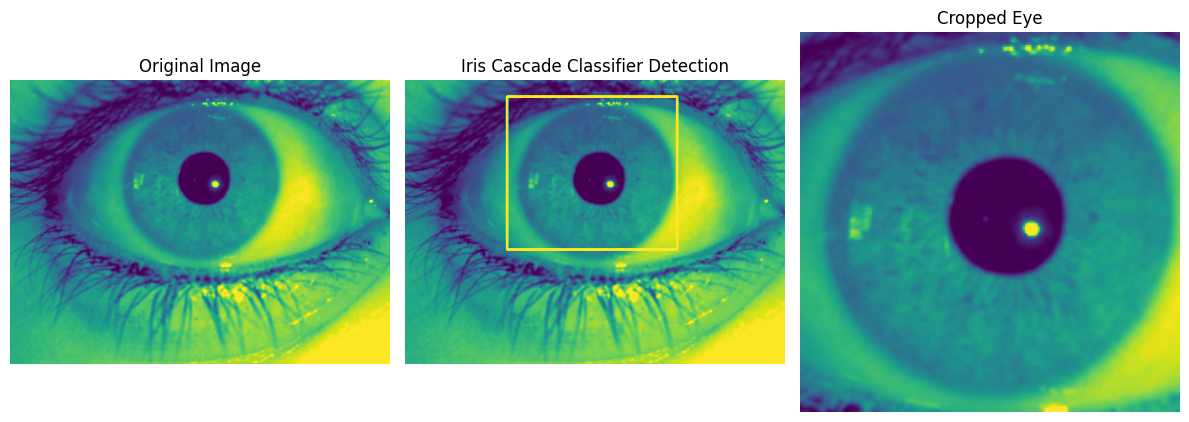

total_eyes_found =  45
total_eyes_found 2 =  0
total images:  45


In [ ]:
eye_images = parse_iris_dataset()
iris_detection(eye_images, 1) #param 2 is for display (1 = display, 0 = don't display)
